# Ques 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import learning_curve
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('diabetes2.csv')

In [3]:
#adding extra column to get equation w0 +w1x1+w2x2+...
extra_column=np.ones(768)
df['Extra']=extra_column

In [4]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Extra
0,6,148,72,35,0,33.6,0.627,50,1,1.0
1,1,85,66,29,0,26.6,0.351,31,0,1.0
2,8,183,64,0,0,23.3,0.672,32,1,1.0
3,1,89,66,23,94,28.1,0.167,21,0,1.0
4,0,137,40,35,168,43.1,2.288,33,1,1.0
5,5,116,74,0,0,25.6,0.201,30,0,1.0
6,3,78,50,32,88,31.0,0.248,26,1,1.0
7,10,115,0,0,0,35.3,0.134,29,0,1.0
8,2,197,70,45,543,30.5,0.158,53,1,1.0
9,8,125,96,0,0,0.0,0.232,54,1,1.0


In [5]:
print(len(df))

768


In [6]:
def preprocess(df):
    cols=df.columns
    cols=cols.drop('Outcome')
    cols=cols.drop('Extra')
    
    for i in cols:
         df[i]=(df[i]-df[i].mean())/df[i].std()
    
    return df

In [7]:
df=preprocess(df)

In [8]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Extra
0,0.639530,0.847771,0.149543,0.906679,-0.692439,0.203880,0.468187,1.425067,1,1.0
1,-0.844335,-1.122665,-0.160441,0.530556,-0.692439,-0.683976,-0.364823,-0.190548,0,1.0
2,1.233077,1.942458,-0.263769,-1.287373,-0.692439,-1.102537,0.604004,-0.105515,1,1.0
3,-0.844335,-0.997558,-0.160441,0.154433,0.123221,-0.493721,-0.920163,-1.040871,0,1.0
4,-1.141108,0.503727,-1.503707,0.906679,0.765337,1.408828,5.481337,-0.020483,1,1.0
5,0.342757,-0.153085,0.252871,-1.287373,-0.692439,-0.810813,-0.817546,-0.275580,0,1.0
6,-0.250789,-1.341602,-0.987066,0.718617,0.071158,-0.125895,-0.675693,-0.615709,1,1.0
7,1.826623,-0.184362,-3.570271,-1.287373,-0.692439,0.419502,-1.019762,-0.360612,0,1.0
8,-0.547562,2.380333,0.046215,1.533551,4.019303,-0.189314,-0.947326,1.680164,1,1.0
9,1.233077,0.128406,1.389481,-1.287373,-0.692439,-4.057829,-0.723983,1.765196,1,1.0


In [9]:
#randomizing rows to select for train-val-test set
def train_val_test_split(data, train,val,test):
    """ a function that will get dataset and training dataset fraction as input and return x_train, x_test, y_train, y_test """
    
    train_samples=len(data)*train//(train+test+val)
    val_samples=len(data)*val//(train+test+val)
    train_data=data.iloc[:train_samples,:]
    val_data=data.iloc[train_samples+1:train_samples+val_samples,:]
    test_data=data.iloc[train_samples+val_samples+1:,:]
    
    train_labels=train_data['Outcome']
    val_labels=val_data['Outcome']
    test_labels=test_data['Outcome']
    
    train_data=train_data.drop(['Outcome'],axis=1)
    test_data=test_data.drop(['Outcome'],axis=1)
    val_data=val_data.drop(['Outcome'],axis=1)
    
    return train_data,train_labels,val_data,val_labels,test_data,test_labels

In [10]:
train_data,train_labels,val_data,val_labels,test_data,test_labels=train_val_test_split(df,7,2,1)

# Part 2.1 a)  Logistic Regression


In [13]:
def predict(x):
    sig=sigmoid(x)
    if(sig>0.5):
        return 1
    return 0

def sigmoid(x):
    return(1/(1+np.exp(-1*x)))

def loss_per_sample(x,truth):
    loss=truth*np.log(sigmoid(x))+(1-truth)*np.log(1-sigmoid(x))
    loss*=-1
    return loss

def loss_gradient_per_sample(x,truth):
    return(sigmoid(x)-truth)

def normal_plot(a,b):
    plt.plot(a,b)
    plt.show()
    
def plot(x,a,b,c,d):
    for i in x:
        plt.scatter(i[0],i[1],c=d)
    plt.xlabel(a)
    plt.ylabel(b)

    plt.title(c)
    plt.show()

In [14]:
train_data.shape

(537, 9)

# BGD

In [81]:
def batch_logistic(train_data,train_labels,val_data,val_labels,lr,epochs):
    w=np.random.rand(9,1)
    train_data=train_data.values.tolist()
    train_data=np.array(train_data)
    train_labels=train_labels.values.tolist()
    train_labels=np.array(train_labels)
    train_labels=train_labels.reshape((len(train_labels),1))
    
    val_data=val_data.values.tolist()
    val_data=np.array(val_data)
    val_labels=val_labels.values.tolist()
    val_labels=np.array(train_labels)
    
    iterations_vs_loss=[]
    iterations_vs_val_loss=[]
    
    for i in range(epochs):
        loss=0
        loss_gradient=0
        val_loss=0
        
        values=np.matmul(train_data,w)
        for k in range(len(values)):
            loss+=loss_per_sample(values[k],train_labels[k])
        
        val_values=np.matmul(val_data,w)
        for k in range(len(val_values)):
            val_loss+=loss_per_sample(val_values[k],val_labels[k])
            
        loss=loss/len(train_data)
        iterations_vs_loss.append((i,loss))
        val_loss=val_loss/len(val_data)
        iterations_vs_val_loss.append((i,val_loss))
            
        change=0
        for k in range(len(train_data)):
            pred=np.matmul(train_data[k],w)
            vari=train_data[k]
            vari=vari.reshape((9,1))
            change+=vari*(sigmoid(pred)-train_labels[k])
            
        w=w-lr*change
    
    plot(iterations_vs_loss,"Number of epoch","Training Loss","BGD Training loss vs epochs (logistic regression from scratch)",'r')
    plot(iterations_vs_val_loss,"Number of epoch","Validation Loss","BGD Validation loss vs epochs (logistic regression from scratch)",'b')
    
    return w

# BGD Plots

### Analyis: Training loss is decreasing as it should but validation loss is increasing after the 30th epoch hence overfitting the model slightly
### So number of epochs required to converge and not overfit will be around 30, also loss is quite low hence the model is tending towards low variance and low bias (if we stop training around 30 epochs, else after that variance will be high)

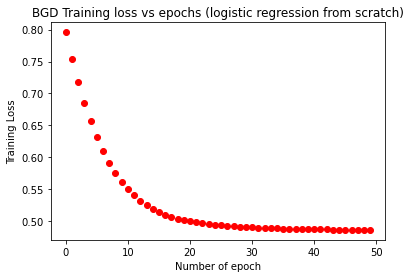

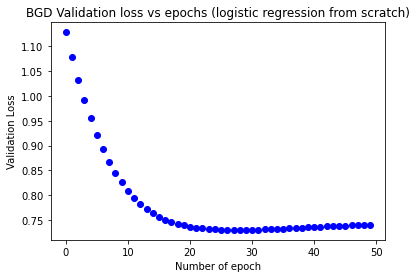

In [247]:
batch_weights=batch_logistic(train_data,train_labels,val_data,val_labels,0.001,50)

# SGD


In [83]:
def stochaistic_logistic(train_data,train_labels,val_data,val_labels,lr,epochs):
    w=np.random.rand(9,1)
    train_data=train_data.values.tolist()
    train_data=np.array(train_data)
    train_labels=train_labels.values.tolist()
    train_labels=np.array(train_labels)
    train_labels=train_labels.reshape((len(train_labels),1))
    
    val_data=val_data.values.tolist()
    val_data=np.array(val_data)

    iterations_vs_loss=[]
    val_labels=val_labels.values.tolist()
    iterations_vs_val_loss=[]
    
    for i in range(epochs):
        loss=0
        val_loss=0
        
        for k in range(len(train_data)):
            pred=np.matmul(train_data[k],w)
            vari=train_data[k]
            vari=vari.reshape((9,1))
            w=w-lr*vari*(sigmoid(pred)-train_labels[k])
        
        values=np.matmul(train_data,w)
        for k in range(len(values)):
            loss+=loss_per_sample(values[k],train_labels[k])
        
        val_values=np.matmul(val_data,w)
        for k in range(len(val_values)):
            val_loss+=loss_per_sample(val_values[k],val_labels[k])
            
        loss=loss/len(train_data)
        val_loss=val_loss/len(val_data)
        iterations_vs_loss.append((i,loss))
        iterations_vs_val_loss.append((i,val_loss))
        
    plot(iterations_vs_loss,"Number of epoch","Training Loss","SGD Training loss vs epochs (logistic regression from scratch)",'r')
    plot(iterations_vs_val_loss,"Number of epoch","Validation Loss","SGD Validation loss vs epochs (logistic regression from scratch)",'b')
    
    return w

# SGD Plots
### Analyis: Both training and validation loss are decreasing, hence model is tending towards low bias and low variance

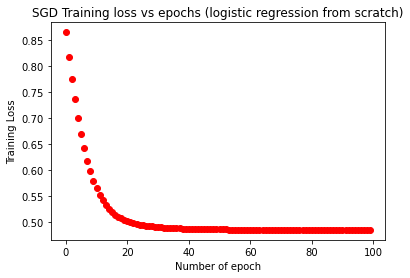

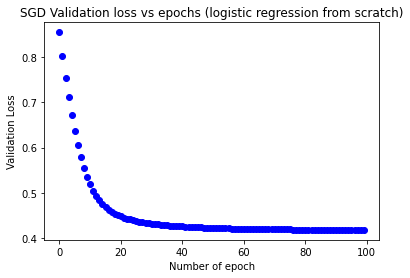

In [84]:
stochaistic_weights=stochaistic_logistic(train_data,train_labels,val_data,val_labels,0.001,100)

# Part 2.1 b)

## Analyisis: 

### for 0.01 : the learning rate is good as Logistic Regression is able to converge and time is also less
### for 0.0001 : the learning rate is too slow as Logistic Regression will converge very slowly (is not converging in 100 epochs)
### for 10 : the learning rate is too high as Logistic Regression is unable to converge as loss is shooting up and going to infinity, so are the weights (warnings are ignored)



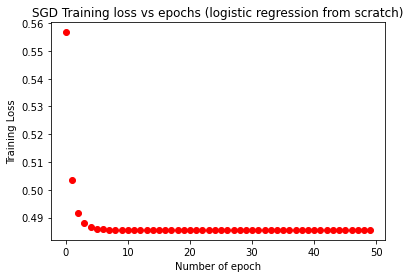

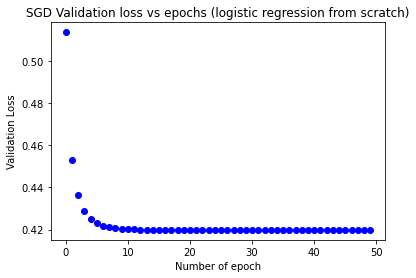

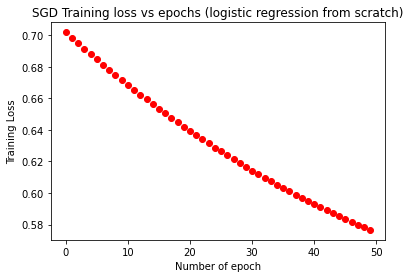

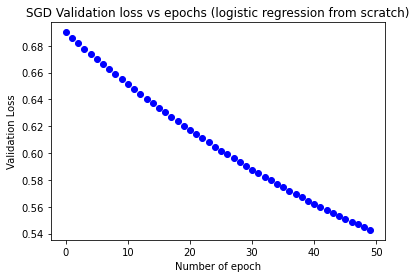

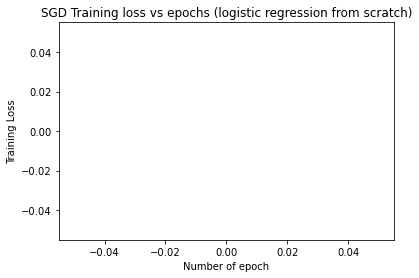

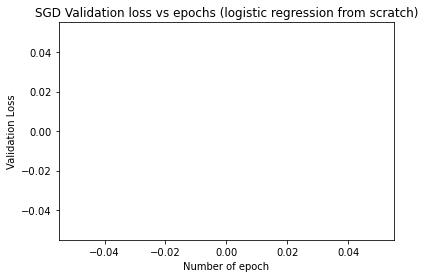

In [248]:
lrs=[0.01,0.0001,10]
for i in lrs:
    stochaistic_logistic(train_data,train_labels,val_data,val_labels,i,50)

# Part 2.1 c)

In [257]:
def final_prediction(test_data,test_labels,stochaistic_weights,batch_weights):
    test_data=test_data.values.tolist()
    test_labels=test_labels.values.tolist()
    
    s_values=np.matmul(test_data,stochaistic_weights)
    b_values=np.matmul(test_data,batch_weights)
    
    s_predictions=[]
    b_predictions=[]
    
    s_true_positives=0
    s_false_negatives=0
    s_false_positives=0
    s_true_negatives=0
    
    b_true_positives=0
    b_false_negatives=0
    b_false_positives=0
    b_true_negatives=0
    
    for i in range(len(s_values)):
        s_predictions.append(predict(s_values[i]))
        b_predictions.append(predict(b_values[i]))
        
        s_values[i]=sigmoid(s_values[i])
        b_values[i]=sigmoid(b_values[i])
        
        if(s_predictions[i]==1 and test_labels[i]==1):
            s_true_positives+=1
        elif(s_predictions[i]==1 and test_labels[i]==0):
            s_false_positives+=1
        elif(s_predictions[i]==0 and test_labels[i]==1):
            s_false_negatives+=1
        else:
            s_true_negatives+=1
            
        if(b_predictions[i]==1 and test_labels[i]==1):
            b_true_positives+=1
        elif(b_predictions[i]==1 and test_labels[i]==0):
            b_false_positives+=1
        elif(b_predictions[i]==0 and test_labels[i]==1):
            b_false_negatives+=1
        else:
            b_true_negatives+=1
    
    s_confusion_matrix=[[s_true_positives,s_false_positives],[s_false_negatives,s_true_negatives]]
    b_confusion_matrix=[[b_true_positives,b_false_positives],[b_false_negatives,b_true_negatives]]
    
    print("SGD Confusion Matrix: ")
    print(s_confusion_matrix)
    
    s_precision=(s_true_positives)/(s_true_positives+s_false_positives)
    s_recall=(s_true_positives)/(s_true_positives+s_false_negatives)
    s_f1=2*s_recall*s_precision/(s_recall+s_precision)
    
    b_precision=(b_true_positives)/(b_true_positives+b_false_positives)
    b_recall=(b_true_positives)/(b_true_positives+b_false_negatives)
    b_f1=2*b_recall*b_precision/(b_recall+b_precision)
    
    print("SGD Accuracy is: "+str(100*(s_true_positives+s_true_negatives)/len(s_values))+" %")
    print("SGD Precision is: "+str(s_precision))
    print("SGD Recall is: "+str(s_recall))
    print("SGD F1 score is: "+str(s_f1))
    print()
    
    print("SGD Confusion Matrix: ")
    print(b_confusion_matrix)
    print("BGD Accuracy is: "+str(100*(b_true_positives+b_true_negatives)/len(b_values))+" %")
    print("BGD Precision is: "+str(b_precision))
    print("BGD Recall is: "+str(b_recall))
    print("BGD F1 score is: "+str(b_f1))
    

## Evalutation Metrics

In [258]:
final_prediction(test_data,test_labels,stochaistic_weights,batch_weights)

SGD Confusion Matrix: 
[[18, 3], [13, 43]]
SGD Accuracy is: 79.22077922077922 %
SGD Precision is: 0.8571428571428571
SGD Recall is: 0.5806451612903226
SGD F1 score is: 0.6923076923076923

SGD Confusion Matrix: 
[[18, 3], [13, 43]]
BGD Accuracy is: 79.22077922077922 %
BGD Precision is: 0.8571428571428571
BGD Recall is: 0.5806451612903226
BGD F1 score is: 0.6923076923076923


# Part 2.2

In [15]:
iterations=np.linspace(1,50,50)
for i in range(len(iterations)):
    iterations[i]=int(iterations[i])

-- Epoch 1
Norm: 0.17, NNZs: 9, Bias: -0.070153, T: 537, Avg. loss: 0.660304
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 0.17, NNZs: 9, Bias: -0.070481, T: 537, Avg. loss: 0.660297
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.30, NNZs: 9, Bias: -0.124649, T: 1074, Avg. loss: 0.610885
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 0.17, NNZs: 9, Bias: -0.069414, T: 537, Avg. loss: 0.660455
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.30, NNZs: 9, Bias: -0.122906, T: 1074, Avg. loss: 0.610972
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.41, NNZs: 9, Bias: -0.163441, T: 1611, Avg. loss: 0.579696
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 0.17, NNZs: 9, Bias: -0.070073, T: 537, Avg. loss: 0.660362
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.30, NNZs: 9, Bias: -0.122913, T: 1074, Avg. loss: 0.610851
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.41, NNZs: 9, Bias: -0.164088, T: 1611, Avg. loss: 0.579562
Total training time: 0

-- Epoch 1
Norm: 0.17, NNZs: 9, Bias: -0.068710, T: 537, Avg. loss: 0.660560
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.30, NNZs: 9, Bias: -0.121341, T: 1074, Avg. loss: 0.611136
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.41, NNZs: 9, Bias: -0.163846, T: 1611, Avg. loss: 0.579899
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.50, NNZs: 9, Bias: -0.196706, T: 2148, Avg. loss: 0.559078
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.57, NNZs: 9, Bias: -0.223470, T: 2685, Avg. loss: 0.544544
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.64, NNZs: 9, Bias: -0.245411, T: 3222, Avg. loss: 0.533965
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.70, NNZs: 9, Bias: -0.263353, T: 3759, Avg. loss: 0.525960
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.75, NNZs: 9, Bias: -0.278698, T: 4296, Avg. loss: 0.519733
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.79, NNZs: 9, Bias: -0.291097, T: 4833, Avg. loss: 0.514773
Total training time

-- Epoch 1
Norm: 0.17, NNZs: 9, Bias: -0.069718, T: 537, Avg. loss: 0.660436
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.30, NNZs: 9, Bias: -0.123013, T: 1074, Avg. loss: 0.610618
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.41, NNZs: 9, Bias: -0.164422, T: 1611, Avg. loss: 0.579371
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.50, NNZs: 9, Bias: -0.198517, T: 2148, Avg. loss: 0.558643
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 0.58, NNZs: 9, Bias: -0.225204, T: 2685, Avg. loss: 0.544162
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.64, NNZs: 9, Bias: -0.247064, T: 3222, Avg. loss: 0.533677
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.70, NNZs: 9, Bias: -0.266345, T: 3759, Avg. loss: 0.525713
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.75, NNZs: 9, Bias: -0.281170, T: 4296, Avg. loss: 0.519529
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.79, NNZs: 9, Bias: -0.294626, T: 4833, Avg. loss: 0.514593
Total training time

Norm: 0.17, NNZs: 9, Bias: -0.069910, T: 537, Avg. loss: 0.660506
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.30, NNZs: 9, Bias: -0.123381, T: 1074, Avg. loss: 0.610993
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.41, NNZs: 9, Bias: -0.164029, T: 1611, Avg. loss: 0.579710
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.50, NNZs: 9, Bias: -0.197124, T: 2148, Avg. loss: 0.558938
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.57, NNZs: 9, Bias: -0.224100, T: 2685, Avg. loss: 0.544406
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.64, NNZs: 9, Bias: -0.245971, T: 3222, Avg. loss: 0.533764
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.70, NNZs: 9, Bias: -0.264220, T: 3759, Avg. loss: 0.525746
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.75, NNZs: 9, Bias: -0.278904, T: 4296, Avg. loss: 0.519565
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.79, NNZs: 9, Bias: -0.292484, T: 4833, Avg. loss: 0.514692
Total training time: 0.01 seco

-- Epoch 1
Norm: 0.17, NNZs: 9, Bias: -0.068776, T: 537, Avg. loss: 0.660355
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.30, NNZs: 9, Bias: -0.122453, T: 1074, Avg. loss: 0.610986
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.41, NNZs: 9, Bias: -0.164320, T: 1611, Avg. loss: 0.579758
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 0.50, NNZs: 9, Bias: -0.197274, T: 2148, Avg. loss: 0.558965
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 0.57, NNZs: 9, Bias: -0.223869, T: 2685, Avg. loss: 0.544534
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.64, NNZs: 9, Bias: -0.244823, T: 3222, Avg. loss: 0.533947
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.70, NNZs: 9, Bias: -0.262735, T: 3759, Avg. loss: 0.525958
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.75, NNZs: 9, Bias: -0.279409, T: 4296, Avg. loss: 0.519718
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.79, NNZs: 9, Bias: -0.292196, T: 4833, Avg. loss: 0.514740
Total training time

-- Epoch 1
Norm: 0.17, NNZs: 9, Bias: -0.069057, T: 537, Avg. loss: 0.660450
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.30, NNZs: 9, Bias: -0.122343, T: 1074, Avg. loss: 0.610864
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.41, NNZs: 9, Bias: -0.163242, T: 1611, Avg. loss: 0.579666
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.50, NNZs: 9, Bias: -0.197239, T: 2148, Avg. loss: 0.558895
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.57, NNZs: 9, Bias: -0.224187, T: 2685, Avg. loss: 0.544349
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.64, NNZs: 9, Bias: -0.246646, T: 3222, Avg. loss: 0.533752
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.70, NNZs: 9, Bias: -0.264422, T: 3759, Avg. loss: 0.525778
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.75, NNZs: 9, Bias: -0.279725, T: 4296, Avg. loss: 0.519616
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.79, NNZs: 9, Bias: -0.293373, T: 4833, Avg. loss: 0.514701
Total training time

-- Epoch 1
Norm: 0.17, NNZs: 9, Bias: -0.069333, T: 537, Avg. loss: 0.660491
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.30, NNZs: 9, Bias: -0.122722, T: 1074, Avg. loss: 0.610942
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.41, NNZs: 9, Bias: -0.163578, T: 1611, Avg. loss: 0.579823
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.50, NNZs: 9, Bias: -0.196393, T: 2148, Avg. loss: 0.559065
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.57, NNZs: 9, Bias: -0.223722, T: 2685, Avg. loss: 0.544462
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.64, NNZs: 9, Bias: -0.245406, T: 3222, Avg. loss: 0.533798
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.70, NNZs: 9, Bias: -0.264093, T: 3759, Avg. loss: 0.525777
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.75, NNZs: 9, Bias: -0.279565, T: 4296, Avg. loss: 0.519594
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.79, NNZs: 9, Bias: -0.293428, T: 4833, Avg. loss: 0.514667
Total training time

-- Epoch 1
Norm: 0.17, NNZs: 9, Bias: -0.070427, T: 537, Avg. loss: 0.660284
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.30, NNZs: 9, Bias: -0.122769, T: 1074, Avg. loss: 0.610778
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.41, NNZs: 9, Bias: -0.163592, T: 1611, Avg. loss: 0.579762
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.50, NNZs: 9, Bias: -0.196123, T: 2148, Avg. loss: 0.559018
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.58, NNZs: 9, Bias: -0.223181, T: 2685, Avg. loss: 0.544400
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.64, NNZs: 9, Bias: -0.245619, T: 3222, Avg. loss: 0.533712
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.70, NNZs: 9, Bias: -0.263660, T: 3759, Avg. loss: 0.525716
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.75, NNZs: 9, Bias: -0.279435, T: 4296, Avg. loss: 0.519546
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.79, NNZs: 9, Bias: -0.292286, T: 4833, Avg. loss: 0.514665
Total training time

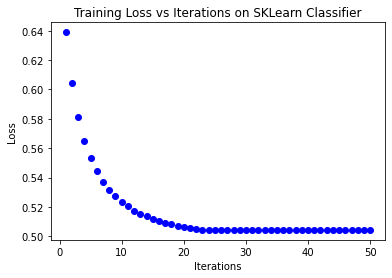

In [18]:
iterations_vs_score=[]
final_model=0
for i in iterations:
    model=SGDClassifier(loss='log',eta0=0.001,max_iter=i,learning_rate='constant',verbose=1).fit(train_data,train_labels)
    
    weights=model.coef_
    pred=np.dot(train_data,weights.T)
    final_model=model
    
    loss=0
    for j in range(len(train_labels)):
        loss+=loss_per_sample(pred[j],train_labels[j])
    loss/=len(train_labels)
    iterations_vs_score.append((i,loss))
    
plot(iterations_vs_score,"Iterations","Loss","Training Loss vs Iterations on SKLearn Classifier",'b')

In [266]:
final_prediction=final_model.predict(test_data)

In [283]:
print("Accuracy using sklearn model "+str(accuracy_score(final_prediction,test_labels)))
print("Precision using sklearn model "+str(precision_score(final_prediction,test_labels)))
print("F1 score using sklearn model "+str(f1_score(final_prediction,test_labels)))
print("Recall using sklearn model "+str(recall_score(final_prediction,test_labels)))


Accuracy using sklearn model 0.7662337662337663
Precision using sklearn model 0.5161290322580645
F1 score using sklearn model 0.6399999999999999
Recall using sklearn model 0.8421052631578947


In [279]:
final_weights=model.coef_
final_weights=final_weights.T
print(final_weights)

[[ 0.32828202]
 [ 0.78396328]
 [-0.13156002]
 [-0.00330558]
 [-0.01536605]
 [ 0.57714739]
 [ 0.25186665]
 [ 0.14772508]
 [-0.37333321]]


In [204]:
print(batch_weights)

[[ 0.40566464]
 [ 0.9859228 ]
 [-0.20584265]
 [ 0.01462753]
 [-0.13499851]
 [ 0.72738881]
 [ 0.29871843]
 [ 0.08765589]
 [-0.82145409]]


In [280]:
print(stochaistic_weights)

[[ 0.42011817]
 [ 0.99033156]
 [-0.20427608]
 [ 0.00554571]
 [-0.13317288]
 [ 0.73462344]
 [ 0.30018106]
 [ 0.0668528 ]
 [-0.82790636]]
